In [2]:
from pathlib import Path
from copy import deepcopy

import NegativeClassOptimization.config as config
import NegativeClassOptimization.datasets as datasets
from NegativeClassOptimization.preprocessing import onehot_encode_df

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from tqdm.notebook import tqdm
from ipywidgets import FloatProgress
import math
import json
import glob
import re
from sklearn.model_selection import train_test_split

In [3]:
from modif_utils import *

In [4]:
from captum.attr import IntegratedGradients

In [5]:
ONE_VS_ALL_PATH = Path('../data/full_data/1_vs_all')
PAIRWISE_HIGH_PATH = Path('../data/full_data/high_pairwise')
HIGH_LOW_PATH = Path('../data/full_data/high_low_concat')

In [6]:
#nn.init.kaiming_normal_(self.fc1.weight)
class SN10_stab(nn.Module):
    """The simple neural network 10 (SN10) model from `Absolut!`.
    """

    def __init__(self, normalize=False):
        super(SN10_stab, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(11*20, 10)
        nn.init.kaiming_normal_(self.linear1.weight)
        self.linear_relu_stack = nn.Sequential(
            self.linear1,
            nn.ReLU(),
            nn.Linear(10, 1),
        )
        self.normalize = normalize 
        if self.normalize:
            self.norm = UnitNormLayer()
        self.sigmoid = nn.Sigmoid()

    def forward_logits(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def forward(
        self, 
        x: torch.Tensor, 
        return_logits = False
        ):
        logits = self.forward_logits(x)
        if self.normalize:
            logits = self.norm(logits)
        expits = self.sigmoid(logits)
        if return_logits:
            return expits, logits
        else:
            return expits

In [117]:
class SN10(nn.Module):
    """The simple neural network 10 (SN10) model from `Absolut!`.
    """

    def __init__(self, normalize=False):
        super(SN10, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11*20, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
        )
        self.normalize = normalize 
        if self.normalize:
            self.norm = UnitNormLayer()
        self.sigmoid = nn.Sigmoid()

    def forward_logits(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def forward(
        self, 
        x: torch.Tensor, 
        return_logits = False
        ):
        logits = self.forward_logits(x)
        if self.normalize:
            logits = self.norm(logits)
        expits = self.sigmoid(logits)
        if return_logits:
            return expits, logits
        else:
            return expits

In [8]:
def get_aa_degree(y_deg):
    y_deg = [*y_deg[:-1]]
    n = 2
    y_deg = [y_deg[i: i+n] for i in range(0, len(y_deg), n)]
    return y_deg
def full_slide_degree(y_slide, y_deg):
    y_slide = [*y_slide]
    y_deg =  get_aa_degree(y_deg)
    j = 0
    deg_full = []
    for i in range(len(y_slide)):
        if y_slide[i] == y_deg[j][0]:
            aa_deg = ''.join(y_deg[j])
            if j < len(y_deg)-1:
                j +=1
        else:
            aa_deg = y_slide[i] +'0'
        deg_full.append(aa_deg)
    return deg_full

In [9]:
ONE_VS_ALL_PATH = Path('../data/full_data/1_vs_all')

In [10]:
antigens = ['3VRL', '1NSN', '3RAJ', '5E94', '1H0D', '1WEJ', '1ADQ', '1FBI','2YPV', '1OB1']  

In [11]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
loss_fn = nn.BCELoss()

In [12]:
#modify in a following way
#just calculate netrics on some dataset
#tets type - nme of test
#closed column should be same for all

In [13]:
#= f'_vs_all_repl_[0-9]*_swa.pt'
def get_perf(models_path, model_suf, data_root, path_suf_data, base_model, test_type, trained_on):
    list_4_df= []
    for ag in antigens: 
        models = glob.glob(models_path + ag + model_suf)
        df_data = pd.read_csv(data_root / (ag+ path_suf_data), sep='\t')
        df_data = df_data[df_data['Train'] == False].reset_index(drop =True)
        df_data = dataset_preprosessing(df_data)
        dataloader = DataLoader(df_data, batch_size=df_data.__len__(), shuffle=True)

        for model_path in models:
            model = base_model
            model.load_state_dict(torch.load(model_path))
            model = model.to(device)

            repl = model_path.split('/')[-1]
            repl = re.search('\.*repl_(\d*)', repl).group(1)

            performance = dict()
            for batch, (X, y) in enumerate(dataloader): 
                performance = test_loop(model, X, y, device, loss_fn)
            performance[0] = float(np.mean(performance[0]))
            list_4_df.append([ag, test_type, trained_on, repl] + performance)



    performance_df = pd.DataFrame(list_4_df, columns = ['ag', 'test type', 'trained on', 'repl', 'loss', 'acc', 'recall', 'prec', 'f1'])
    return performance_df

In [14]:
#= f'_vs_all_repl_[0-9]*_swa.pt'
def test_ig(models_path, model_suf, open_root, path_suf_open, closed_root, path_suf_closed, base_model):
    list_4_df= []
    for ag in antigens: 
        models = glob.glob(models_path + ag + model_suf)
        df_open = pd.read_csv(open_root / (ag+ path_suf_open), sep='\t')
        df_open = df_open[df_open['Train'] == False].reset_index(drop =True)
        df_open = dataset_preprosessing(df_open)
        open_dataloader = DataLoader(df_open, batch_size=df_open.__len__(), shuffle=True)

        df_closed = pd.read_csv(closed_root / (ag + path_suf_closed), sep='\t')
        df_closed = df_closed[df_closed['Train'] == False].reset_index(drop =True)
        df_closed = dataset_preprosessing(df_closed)
        closed_dataloader = DataLoader(df_closed, batch_size=df_closed.__len__(), shuffle=True)
        for model_path in models:
            model = base_model
            model.load_state_dict(torch.load(model_path))
            model = model.to(device)

            repl = model_path.split('/')[-1]
            repl = re.search('\.*_repl_(\d*)', repl).group(1)

            open_performance = dict()
            for batch, (X, y) in enumerate(open_dataloader): 
                open_performance = test_loop(model, X, y, device, loss_fn)
            open_performance[0] = float(np.mean(open_performance[0]))
            list_4_df.append([ag, 'open', repl] + open_performance)

            closed_performance = dict()
            for batch, (X, y) in enumerate(closed_dataloader): 
                closed_performance = test_loop(model, X, y, device, loss_fn)
            closed_performance[0] = float(np.mean(closed_performance[0]))
            list_4_df.append([ag, 'closed', repl] + closed_performance)

    performance_df = pd.DataFrame(list_4_df, columns = ['ag', 'test type', 'repl', 'loss', 'acc', 'recall', 'prec', 'f1'])
    return performance_df



## Final models

In [90]:
#1 vs all
models_path = './torch_models/SN10_1_vs_all/'
model_suf = '_vs_all_repl_[0-9]*_swa.pt'
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
closed_root = ONE_VS_ALL_PATH
path_suf_closed = '_vs_all.tsv'
closed_one_all = get_perf(models_path, model_suf, closed_root, path_suf_closed, swa_model, test_type = '1 vs all', trained_on = '1 vs all')

In [91]:
open_root = HIGH_LOW_PATH
path_suf_open = '_high_95low.tsv'
test_type = '95low'
closed_one_all_open_95low = get_perf(models_path, model_suf, open_root, path_suf_open, swa_model, test_type = test_type, trained_on = '1 vs all')

In [92]:
open_root = HIGH_LOW_PATH
path_suf_open = '_high_looser.tsv'
test_type = 'looser'
closed_one_all_open_looser = get_perf(models_path, model_suf, open_root, path_suf_open, swa_model, test_type = test_type, trained_on = '1 vs all')

In [95]:
one_all_full = pd.concat([closed_one_all_open_looser, closed_one_all, closed_one_all_open_95low])

## Trained on 1_vs_all

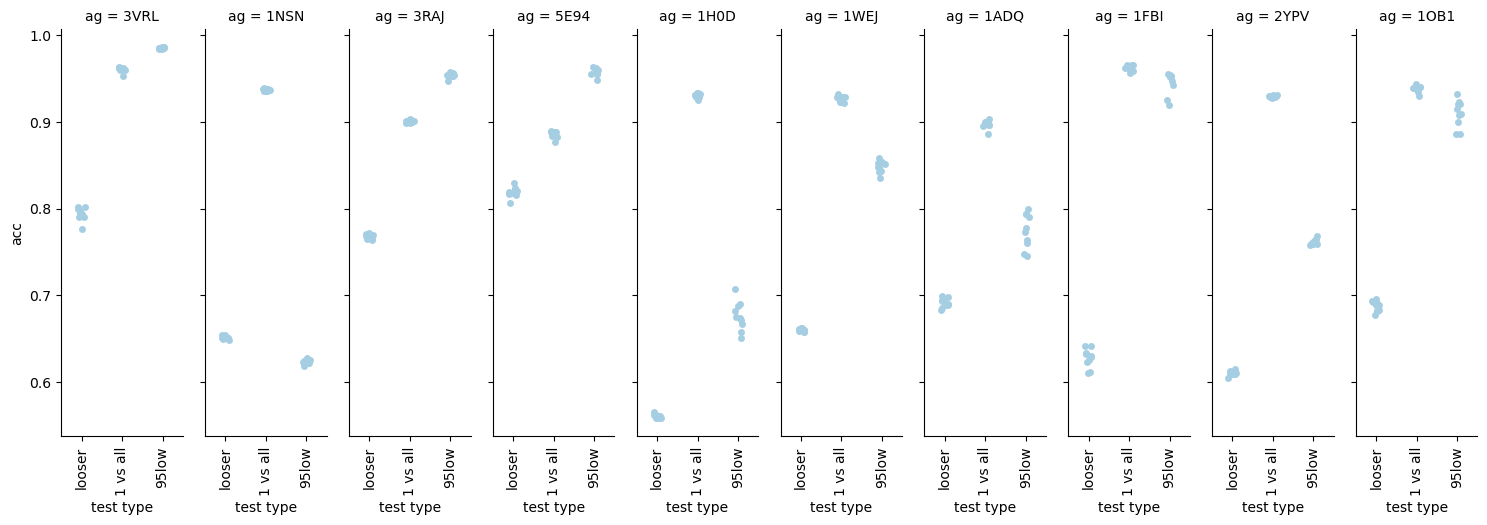

In [165]:
g = sns.catplot(one_all_full, x ='test type', y ='acc', col='ag', aspect=0.3, color = '#a6cee3')
g.set_xticklabels(rotation=90)
plt.savefig('./plots/one_all_perf.png')
#print('closed: 1 vs all, open: low95 ')

In [97]:
#looser
models_path = './torch_models/SN10_high_low/'
model_suf = '_high_looser_repl_[0-9]*_swa.pt'
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
closed_root = HIGH_LOW_PATH
path_suf_closed = '_high_looser.tsv'
closed_looser = get_perf(models_path, model_suf, closed_root, path_suf_closed, swa_model, test_type = 'looser', trained_on = 'looser')

In [98]:
open_root = HIGH_LOW_PATH
path_suf_open = '_high_95low.tsv'
test_type = '95low'
closed_looser_open_95low = get_perf(models_path, model_suf, open_root, path_suf_open, swa_model, test_type = test_type, trained_on = 'looser')

In [102]:
open_root = ONE_VS_ALL_PATH
path_suf_open = '_vs_all.tsv'
test_type = '1 vs all'
closed_looser_open_one_all = get_perf(models_path, model_suf, open_root, path_suf_open, swa_model, test_type = test_type, trained_on = 'looser')

In [103]:
looser_full = pd.concat([closed_looser, closed_looser_open_one_all, closed_looser_open_95low])

# trained on looser binders

In [ ]:
## g = sns.catplot(looser_full, x ='test type', y ='acc', col='ag', aspect=0.3, color='#b2df8a')
g.set_xticklabels(rotation=90)
plt.savefig('./plots/looser_perf.png')

In [106]:
#95low
models_path = './torch_models/SN10_high_low/'
model_suf = '_high_95low_repl_[0-9]*_swa.pt'
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
closed_root = HIGH_LOW_PATH
path_suf_closed = '_high_95low.tsv'
closed_95low = get_perf(models_path, model_suf, closed_root, path_suf_closed, swa_model, test_type = '95low', trained_on = '95low')

In [107]:
open_root = ONE_VS_ALL_PATH
path_suf_open = '_vs_all.tsv'
test_type = '1 vs all'
closed_95low_open_one_all = get_perf(models_path, model_suf, open_root, path_suf_open, swa_model, test_type = test_type, trained_on = '95low')

In [108]:
open_root = HIGH_LOW_PATH
path_suf_open = '_high_looser.tsv'
test_type = 'looser'
closed_95low_open_looser = get_perf(models_path, model_suf, open_root, path_suf_open, swa_model, test_type = test_type, trained_on = '95low')

In [109]:
low95_full = pd.concat([closed_95low_open_looser, closed_95low_open_one_all, closed_95low])

# Trined on non-binders

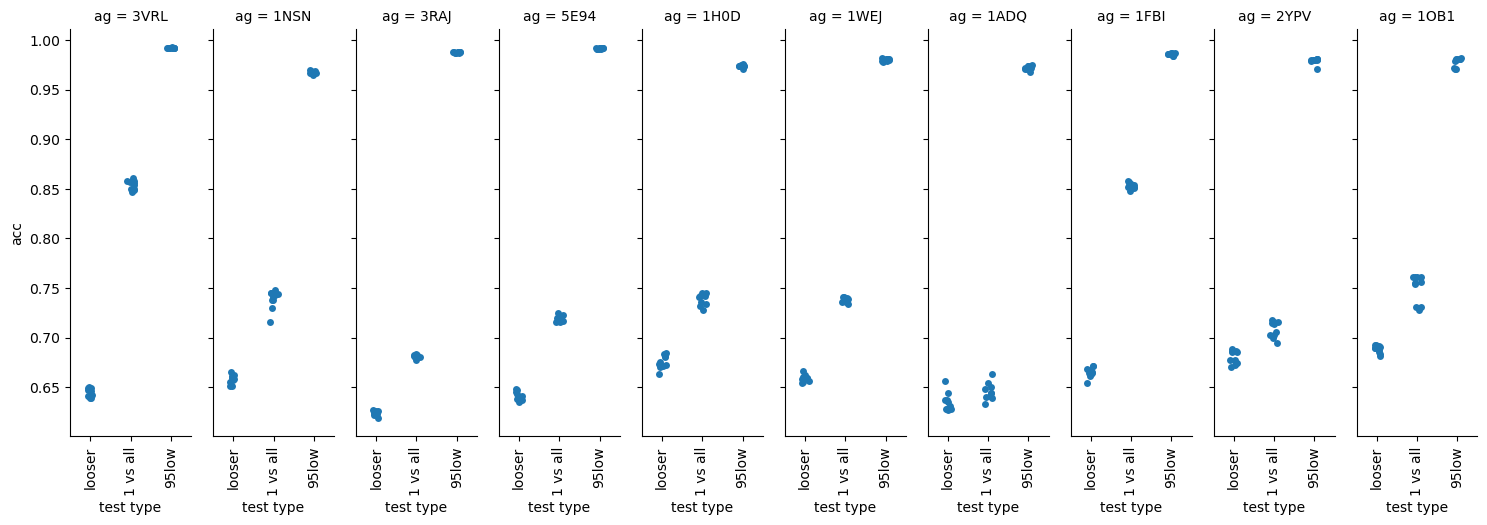

In [167]:
g = sns.catplot(low95_full, x ='test type', y ='acc', col='ag', aspect=0.3, color = '#1f78b4')
g.set_xticklabels(rotation=90)
plt.savefig('./plots/95low_perf.png')
#plt.xticks(rotation=90)

In [134]:
#mix
#looser
models_path = './torch_models/SN10_one_vs_mix/'
model_suf = '_vs_mix_allrepl_[0-9]*_swa.pt'
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
closed_root = ONE_VS_ALL_PATH
path_suf_closed = '_vs_all.tsv'
trained_on = 'one vs mix'
test_type = '1 vs all'
closed_mix = get_perf(models_path, model_suf, closed_root, path_suf_closed, swa_model, test_type = test_type, trained_on = trained_on)

In [122]:
open_root = HIGH_LOW_PATH
path_suf_open = '_high_looser.tsv'
test_type = 'looser'
closed_mix_open_looser = get_perf(models_path, model_suf, open_root, path_suf_open, swa_model, test_type = test_type, trained_on = trained_on)

In [123]:
open_root = HIGH_LOW_PATH
path_suf_open = '_high_95low.tsv'
test_type = '95low'
closed_mix_open_95low = get_perf(models_path, model_suf, open_root, path_suf_open, swa_model, test_type = test_type, trained_on = trained_on)

In [135]:
mix_full = pd.concat([closed_mix_open_looser, closed_mix, closed_mix_open_95low])

# 1_vs_mixed

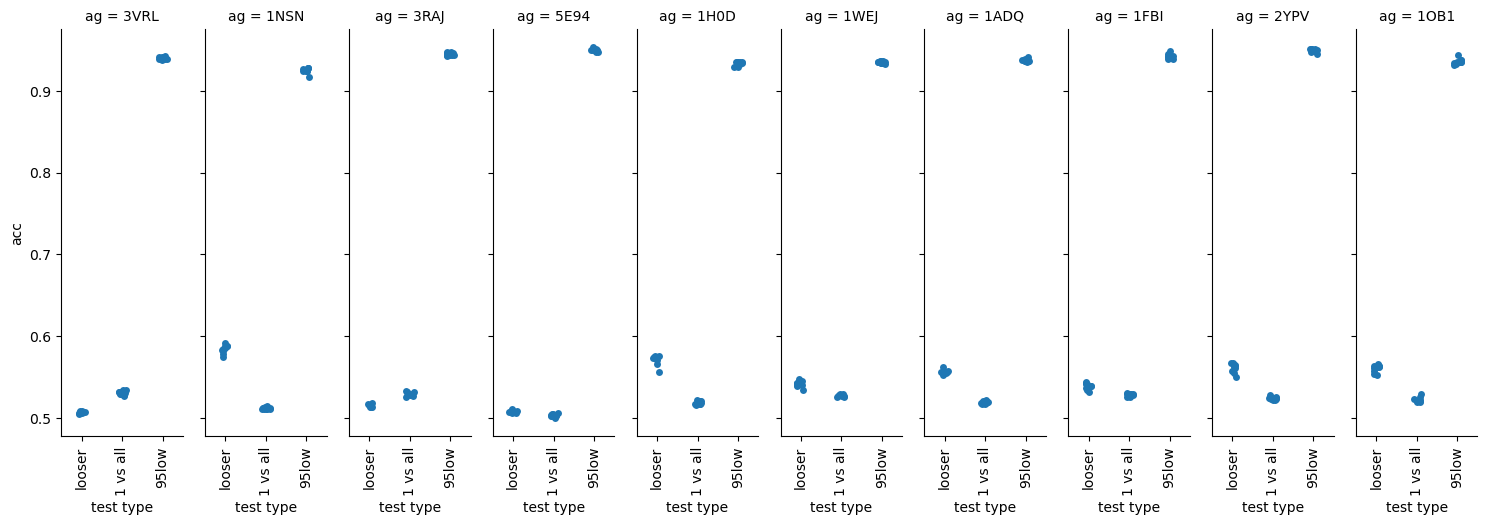

In [136]:
g = sns.catplot(mix_full, x ='test type', y ='acc', col='ag', aspect=0.3)
g.set_xticklabels(rotation=90)

In [137]:
all_trained = pd.concat([one_all_full, low95_full, looser_full])

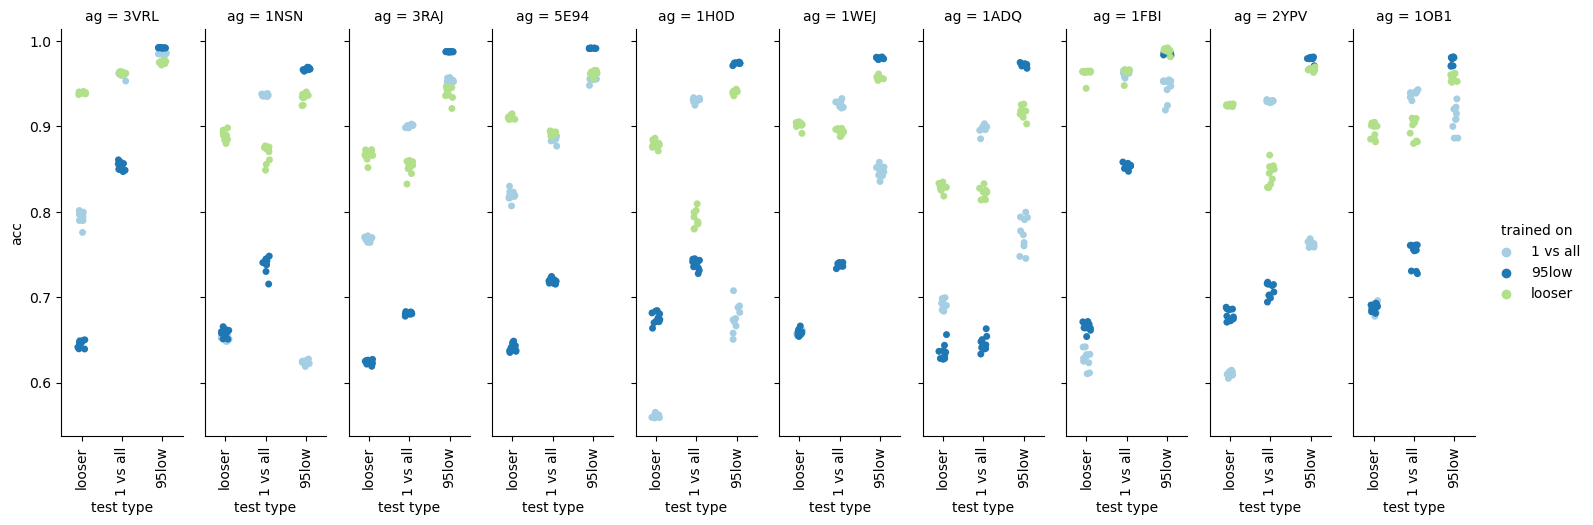

In [164]:
g = sns.catplot(all_trained, x ='test type', y ='acc', col='ag', aspect=0.3, hue='trained on', palette = 'Paired')
g.set_xticklabels(rotation=90)
plt.savefig('./plots/task_depend_perf.png')

In [194]:
low95_full.to_csv('./closed_open_performance/low95_full_perf.csv')
one_all_full.to_csv('./closed_open_performance/one_all_full_perf.csv')
looser_full.to_csv('./closed_open_performance/looser_full_perf.csv')

In [115]:
 """class SN10(nn.Module):
    """The simple neural network 10 (SN10) model from `Absolut!`.
    """

    def __init__(self, normalize=False):
        super(SN10, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(11*20, 10)
        nn.init.kaiming_normal_(self.linear1.weight)
        self.linear_relu_stack = nn.Sequential(
            self.linear1,
            nn.ReLU(),
            nn.Linear(10, 1),
        )
        self.normalize = normalize 
        if self.normalize:
            self.norm = UnitNormLayer()
        self.sigmoid = nn.Sigmoid()

    def forward_logits(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def forward(
        self, 
        x: torch.Tensor, 
        return_logits = False
        ):
        logits = self.forward_logits(x)
        if self.normalize:
            logits = self.norm(logits)
        expits = self.sigmoid(logits)
        if return_logits:
            return expits, logits
        else:
            return expits"""

In [95]:
#95low_base
models_path = './torch_models/SN10_base_95low/'
model_suf = '_high_95low_repl_[0-9].pt'
base_model = SN10()
closed_root = HIGH_LOW_PATH
path_suf_closed = '_high_95low.tsv'
closed_95low_base = get_perf(models_path, model_suf, closed_root, path_suf_closed, base_model, test_type = '95low', trained_on = '95low')

In [96]:
open_root = ONE_VS_ALL_PATH
path_suf_open = '_vs_all.tsv'
test_type = '1 vs all'
closed_95low_base_open_one_all = get_perf(models_path, model_suf, open_root, path_suf_open, base_model, test_type = test_type, trained_on = '95low')

In [97]:
open_root = HIGH_LOW_PATH
path_suf_open = '_high_looser.tsv'
test_type = 'looser'
closed_95low_base_open_looser = get_perf(models_path, model_suf, open_root, path_suf_open, base_model, test_type = test_type, trained_on = '95low')

In [98]:
low95_base_full = pd.concat([closed_95low_base_open_looser, closed_95low_base_open_one_all, closed_95low_base])

In [99]:
#looser_base
models_path = './torch_models/SN10_base_looser/'
model_suf = '_high_looser_repl_[0-9].pt'
base_model = SN10()
closed_root = HIGH_LOW_PATH
path_suf_closed = '_high_looser.tsv'
closed_looser_base = get_perf(models_path, model_suf, closed_root, path_suf_closed, base_model, test_type = 'looser', trained_on = 'looser')

In [100]:
open_root = HIGH_LOW_PATH
path_suf_open = '_high_95low.tsv'
test_type = '95low'
closed_looser_base_open_95low = get_perf(models_path, model_suf, open_root, path_suf_open, base_model, test_type = test_type, trained_on = 'looser')

In [101]:
open_root = ONE_VS_ALL_PATH
path_suf_open = '_vs_all.tsv'
test_type = '1 vs all'
closed_looser_base_open_one_all = get_perf(models_path, model_suf, open_root, path_suf_open, base_model, test_type = test_type, trained_on = 'looser')

In [102]:
looser_base_full = pd.concat([closed_looser_base_open_95low, closed_looser_base_open_one_all, closed_looser_base])

In [118]:
#1 vs base
models_path = './torch_models/SN10_1_vs_all/base_exp/'
model_suf = '_vs_all_repl_[0-9].pt'
base_model = SN10()
closed_root = ONE_VS_ALL_PATH
path_suf_closed = '_vs_all.tsv'
closed_one_base_all = get_perf(models_path, model_suf, closed_root, path_suf_closed, base_model, test_type = '1 vs all', trained_on = '1 vs all')

In [113]:
closed_one_base_all

,ag,test type,trained on,repl,loss,acc,recall,prec,f1


In [119]:
open_root = HIGH_LOW_PATH
path_suf_open = '_high_95low.tsv'
test_type = '95low'
closed_one_all_base_open_95low = get_perf(models_path, model_suf, open_root, path_suf_open, base_model, test_type = test_type, trained_on = '1 vs all')

In [120]:
open_root = HIGH_LOW_PATH
path_suf_open = '_high_looser.tsv'
test_type = 'looser'
closed_one_all_base_open_looser = get_perf(models_path, model_suf, open_root, path_suf_open, base_model, test_type = test_type, trained_on = '1 vs all')

In [121]:
one_all_base_full = pd.concat([closed_one_all_base_open_looser, closed_one_all_base_open_95low, closed_one_base_all])

In [122]:
low95_base_full.to_csv('./closed_open_performance/low95_base_full_perf.csv')
one_all_base_full.to_csv('./closed_open_performance/one_all_base_full_perf.csv')
looser_base_full.to_csv('./closed_open_performance/looser_base_full_perf.csv')

In [124]:
one_all_base_full

,ag,test type,trained on,repl,loss,acc,recall,prec,f1
0,3VRL,looser,1 vs all,5,0.404451,0.856122,0.970204,0.789963,0.870855
1,3VRL,looser,1 vs all,1,0.457727,0.828707,0.979048,0.752720,0.851094
2,3VRL,looser,1 vs all,4,0.408193,0.842313,0.973878,0.771004,0.860647
3,3VRL,looser,1 vs all,9,0.363838,0.862721,0.972381,0.797478,0.876287
4,3VRL,looser,1 vs all,8,0.365495,0.864490,0.978367,0.796875,0.878344
...,...,...,...,...,...,...,...,...,...
85,1OB1,1 vs all,1 vs all,2,0.146411,0.948074,0.958503,0.938958,0.948630
86,1OB1,1 vs all,1 vs all,6,0.153827,0.943650,0.945850,0.941750,0.943796
87,1OB1,1 vs all,1 vs all,1,0.151879,0.943923,0.960816,0.929455,0.944876
88,1OB1,1 vs all,1 vs all,5,0.167343,0.941200,0.953878,0.930334,0.941959


In [125]:
all_base_trained = pd.concat([one_all_base_full, low95_base_full, looser_base_full])

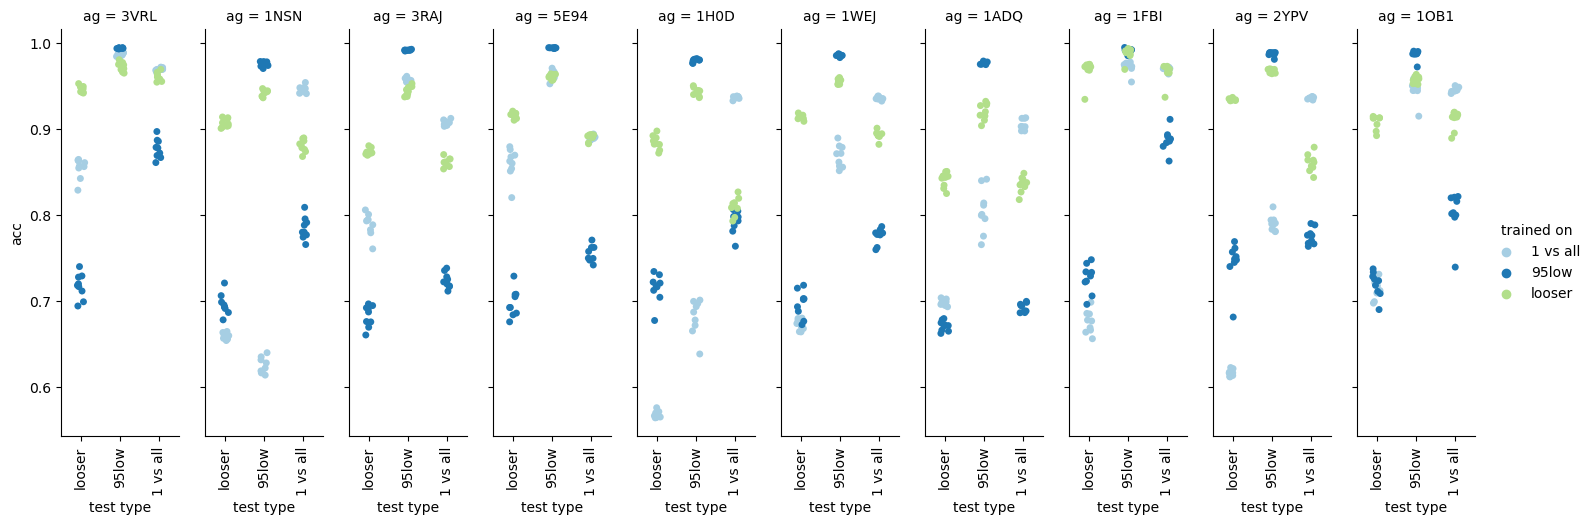

In [126]:
g = sns.catplot(all_base_trained, x ='test type', y ='acc', col='ag', aspect=0.3, hue='trained on', palette = 'Paired')
g.set_xticklabels(rotation=90)
plt.savefig('./plots/task_depend_perf.png')

## Compare performance 

## Old models

In [22]:
models_path = './torch_models/SN10_1_vs_all/swa_exp/'
model_suf = '_vs_all_repl_[0-9]*_swa.pt'
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
open_root = HIGH_LOW_PATH
path_suf_open = '_high_95low.tsv'
closed_root = ONE_VS_ALL_PATH
path_suf_closed = '_vs_all.tsv'

stabilized_perf = test_ig(models_path, model_suf, open_root, path_suf_open, closed_root, path_suf_closed, swa_model)

In [23]:
stabilized_perf.head()

,ag,test type,repl,loss,acc,recall,prec,f1
0,3VRL,open,7,0.056866,0.983469,0.973333,0.993473,0.983300
1,3VRL,closed,7,0.115810,0.958418,0.973333,0.945171,0.959046
2,3VRL,open,5,0.054038,0.985238,0.976599,0.993770,0.985109
3,3VRL,closed,5,0.112560,0.959711,0.976599,0.944722,0.960396
4,3VRL,open,9,0.050325,0.985918,0.976735,0.995010,0.985788


In [24]:
stabilized_perf[stabilized_perf['test type'] == 'closed'].groupby('ag').describe()['acc']

,count,mean,std,min,25%,50%,75%,max
ag,,,,,,,,
1ADQ,20.0,0.861634,0.053606,0.729252,0.829235,0.875149,0.908347,0.916701
1FBI,20.0,0.957415,0.009079,0.940000,0.950408,0.961727,0.964390,0.967402
1H0D,20.0,0.814341,0.124717,0.672177,0.695595,0.822707,0.934650,0.939227
1NSN,20.0,0.785090,0.159762,0.621224,0.630833,0.787913,0.940333,0.944535
1OB1,20.0,0.932713,0.014914,0.892449,0.920918,0.939941,0.944025,0.947053
1WEJ,20.0,0.887101,0.042584,0.831633,0.847058,0.889848,0.927351,0.932353
2YPV,20.0,0.859517,0.077610,0.770000,0.782534,0.863217,0.935399,0.937730
3RAJ,20.0,0.930709,0.026760,0.896012,0.906407,0.927431,0.956650,0.964966
3VRL,20.0,0.973843,0.011298,0.958418,0.963131,0.974415,0.984983,0.986599


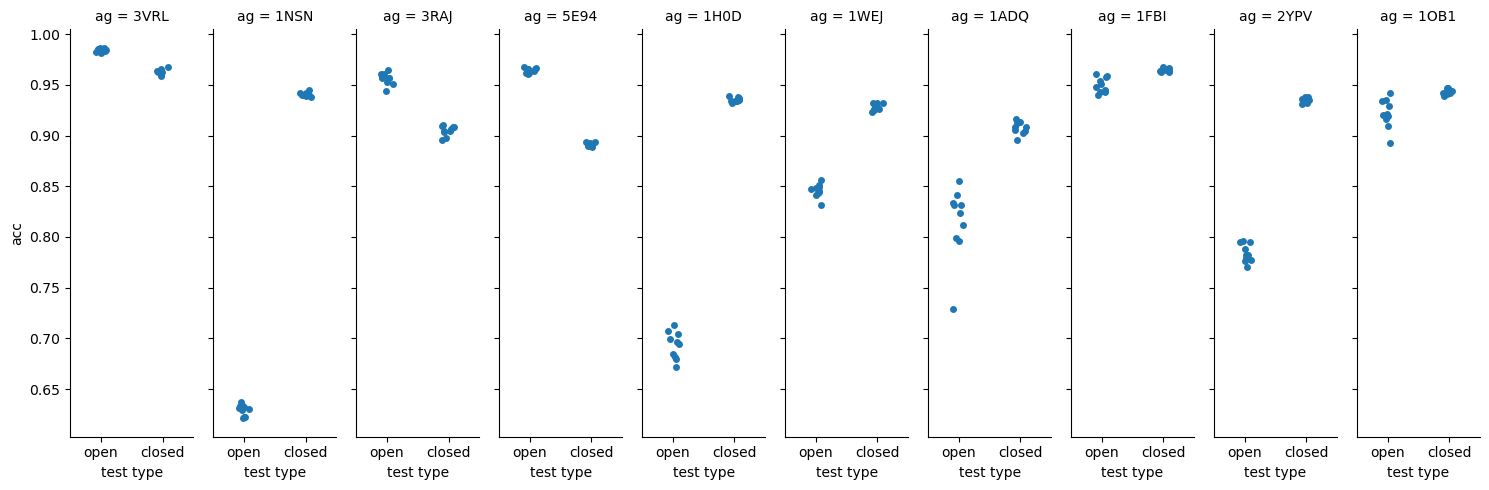

In [25]:
sns.catplot(stabilized_perf, x ='test type', y ='acc', col='ag', aspect=0.3)

In [26]:
#something wrong with these models
models_path = './torch_models/SN10_1_vs_all/base_exp/'
model_suf = '*.pt' #I am missing repl 10
base_model = SN10()
open_root = HIGH_LOW_PATH 
path_suf_open = '_high_95low.tsv'
closed_root = ONE_VS_ALL_PATH
path_suf_closed = '_vs_all.tsv'

sn10_perf = test_ig(models_path, model_suf, open_root, path_suf_open, closed_root, path_suf_closed, base_model)

In [27]:
sn10_perf[sn10_perf['test type'] == 'closed'].groupby('ag').describe()['acc']

,count,mean,std,min,25%,50%,75%,max
ag,,,,,,,,
1ADQ,20.0,0.858202,0.053167,0.765306,0.808554,0.883006,0.902732,0.912958
1FBI,20.0,0.971001,0.004895,0.954626,0.970141,0.971451,0.972874,0.977755
1H0D,20.0,0.807650,0.133134,0.638095,0.684558,0.816755,0.937355,0.938274
1NSN,20.0,0.784822,0.165062,0.613537,0.621241,0.790328,0.944280,0.953995
1OB1,20.0,0.944098,0.011003,0.913673,0.944348,0.945193,0.948658,0.958503
1WEJ,20.0,0.900814,0.037860,0.838639,0.868707,0.910871,0.935161,0.941609
2YPV,20.0,0.861722,0.076289,0.767483,0.789133,0.871449,0.935637,0.937730
3RAJ,20.0,0.931668,0.025677,0.903022,0.906867,0.930424,0.956871,0.961224
3VRL,20.0,0.978072,0.008754,0.966245,0.969579,0.976967,0.986361,0.988844


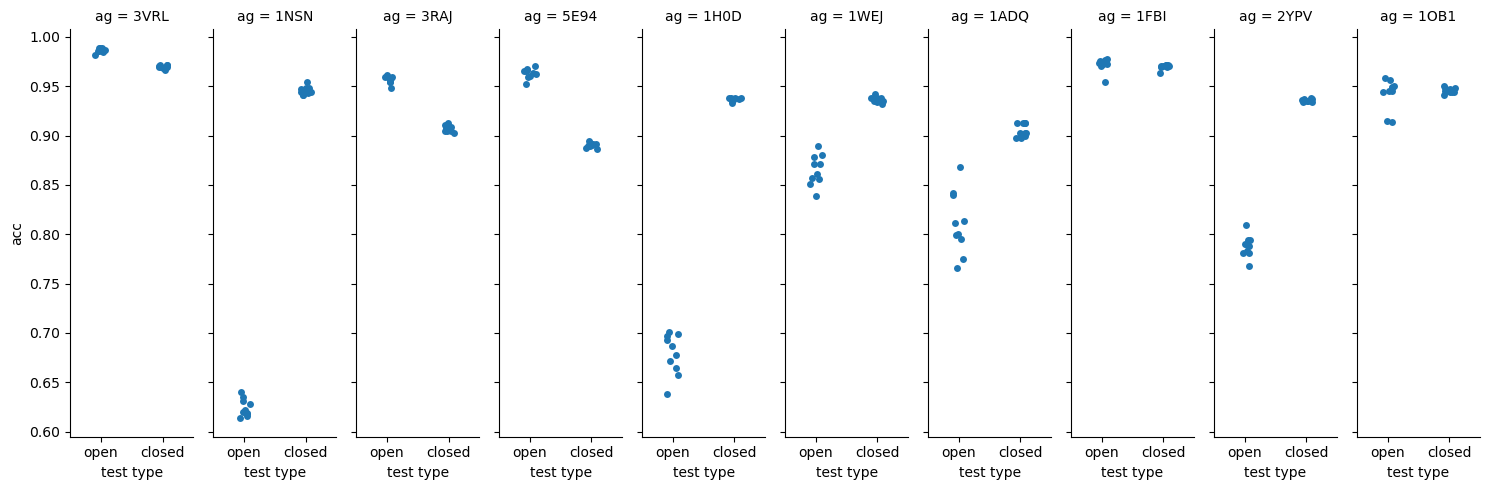

In [29]:
sns.catplot(sn10_perf, x ='test type', y ='acc', col='ag', aspect=0.3)

In [43]:
#high_low
models_path = './torch_models/SN10_high_low/'
model_suf = '_high_95low_repl_[0-9]*_swa.pt' #1H0D_high_95low_repl_2_swa.pt
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
closed_root = HIGH_LOW_PATH 
path_suf_closed = '_high_95low.tsv'
open_root = ONE_VS_ALL_PATH
path_suf_open = '_vs_all.tsv'

sn10_high_low_perf = test_ig(models_path, model_suf, open_root, path_suf_open, closed_root, path_suf_closed, swa_model)

In [44]:
sn10_high_low_perf

,ag,test type,repl,loss,acc,recall,prec,f1
0,3VRL,open,6,0.404884,0.858446,0.997279,0.780618,0.875747
1,3VRL,closed,6,0.034121,0.992245,0.997279,0.987338,0.992284
2,3VRL,open,4,0.438924,0.845515,0.998367,0.764694,0.866045
3,3VRL,closed,4,0.032878,0.991769,0.998367,0.985363,0.991823
4,3VRL,open,8,0.385245,0.864230,0.997823,0.787501,0.880274
...,...,...,...,...,...,...,...,...
195,1OB1,closed,6,0.063269,0.981020,0.996054,0.966979,0.981302
196,1OB1,open,2,0.721693,0.760923,0.995510,0.677688,0.806414
197,1OB1,closed,2,0.064259,0.981020,0.995510,0.967473,0.981291
198,1OB1,open,10,0.685568,0.788417,0.984762,0.707181,0.823202


In [45]:
sn10_high_low_perf[sn10_high_low_perf['test type'] == 'closed'].groupby('ag').describe()['acc']

,count,mean,std,min,25%,50%,75%,max
ag,,,,,,,,
1ADQ,10.0,0.975463,0.002928,0.968707,0.974473,0.976020,0.977517,0.978912
1FBI,10.0,0.987388,0.001315,0.985918,0.986480,0.986871,0.988333,0.989796
1H0D,10.0,0.975537,0.001496,0.972313,0.975323,0.975544,0.976071,0.977551
1NSN,10.0,0.970177,0.002328,0.965782,0.969439,0.970884,0.971786,0.972857
1OB1,10.0,0.983163,0.002516,0.981020,0.981361,0.981905,0.984235,0.988027
1WEJ,10.0,0.980878,0.001559,0.978435,0.979813,0.981395,0.981718,0.983265
2YPV,10.0,0.980619,0.004636,0.970816,0.980935,0.982347,0.982908,0.984626
3RAJ,10.0,0.987850,0.000415,0.986803,0.987857,0.987959,0.988027,0.988299
3VRL,10.0,0.992320,0.000544,0.991633,0.991871,0.992279,0.992653,0.993265


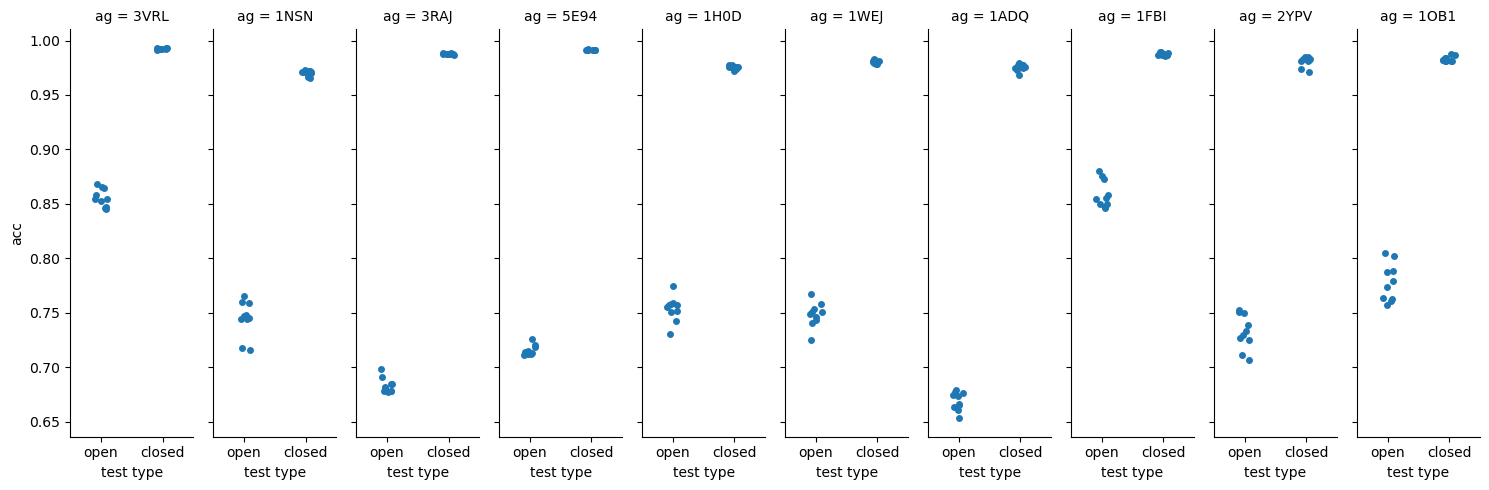

In [46]:
sns.catplot(sn10_high_low_perf, x ='test type', y ='acc', col='ag', aspect=0.3)

In [163]:
sn10_high_low_perf.head()

,ag,test type,repl,loss,acc,recall,prec,f1
0,3VRL,open,6,0.404884,0.858446,0.997279,0.780618,0.875747
1,3VRL,closed,6,0.034121,0.992245,0.997279,0.987338,0.992284
2,3VRL,open,4,0.438924,0.845515,0.998367,0.764694,0.866045
3,3VRL,closed,4,0.032878,0.991769,0.998367,0.985363,0.991823
4,3VRL,open,8,0.385245,0.864230,0.997823,0.787501,0.880274


In [54]:
#high_looser
models_path = './torch_models/SN10_high_low/'
model_suf = '_high_looser_hard_repl_[0-9]*_swa.pt'
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
closed_root = HIGH_LOW_PATH  
path_suf_closed = '_high_looser.tsv'
open_root = ONE_VS_ALL_PATH
path_suf_open = '_vs_all.tsv'

sn10_high_looser_perf = test_ig(models_path, model_suf, open_root, path_suf_open, closed_root, path_suf_closed, swa_model)

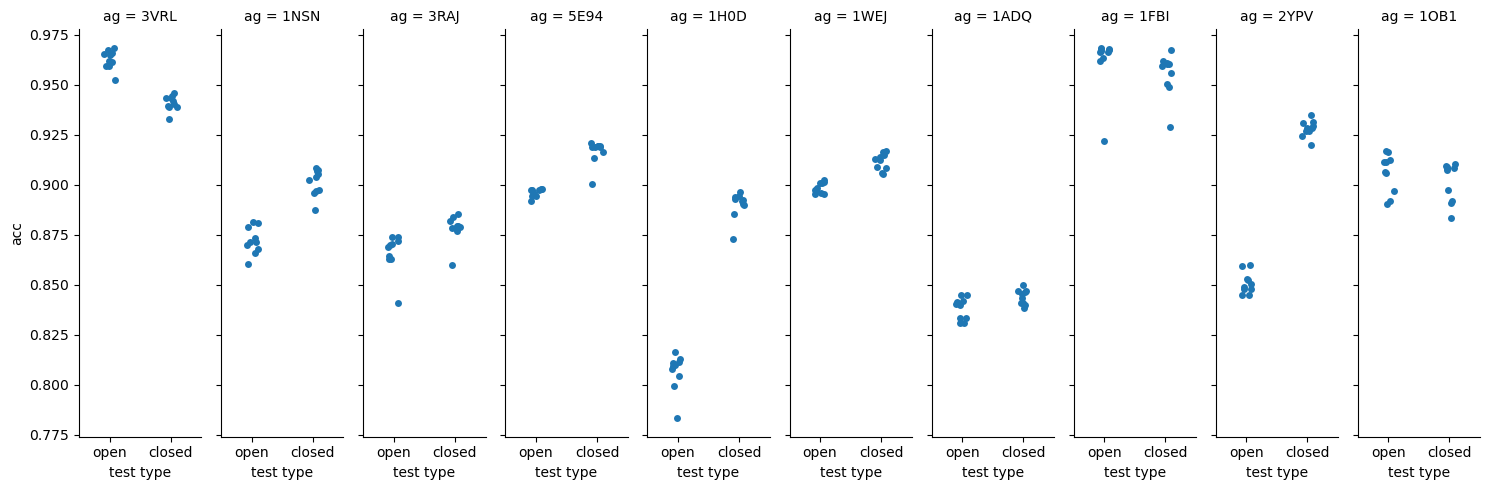

In [57]:
sns.catplot(sn10_high_looser_perf, x ='test type', y ='acc', col='ag', aspect=0.3)

## Calculating IG

In [19]:
b = torch.tensor([0.05]*220)

In [ ]:
b = 

In [51]:
def df_ig(df_closed, df_imp, base_model, model_prefix, model_suffix, model_root, baseline=torch.tensor([0]*220), decoding = True):
    #df_closed = pd.read_csv(ONE_VS_ALL_PATH / '3VRL_vs_all.tsv', sep ='\t')
    df_closed = df_closed[df_closed['Train'] == False]
    df_closed = df_closed[df_closed['binder'] == True].reset_index(drop =True)
    #df_imp = pd.read_csv('../data/Slide_importance/3VRl_C_Task4_Slice_ParaEpi.txt', sep = '\t')
    df_imp = df_imp[['Slide', 'Label','seqABParatope', 'AAcompoFullSlice']]
    df_imp_test = df_closed.merge(df_imp, on = ['Slide'])
    df_imp_test['full_deg_Slide'] = df_imp_test.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
    df_imp_prep = dataset_preprosessing(df_imp_test)
    features = np.array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])
    device = "cpu"
    loss_fn = nn.BCELoss()
    for repl in tqdm(range(1, 11), desc = 'replicates'):
        file_name = f'{model_prefix}_{repl}{model_suffix}' #f'3VRL_vs_all_repl_{repl}_swa'
        model_path = f'./torch_models/{model_root}/{file_name}.pt'
        #load in separate function, do I have to hae differen SN10 model versions to load trained models back?
        model = base_model
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

        ig = IntegratedGradients(model.cpu())
        datatest_loader = DataLoader(df_imp_prep, batch_size=1)
        seqs = []
        imps = []
        y_preds = []
        for X, y in tqdm(datatest_loader, desc = 'Dataset', leave = False):
            y_pred = test_loop(model, X, y, device, loss_fn, compute_loss = False, compute_merics = False, return_class = True)
            y_preds.append(y_pred)
            attr = ig.attribute(X, baseline)
            attr = attr.squeeze()
            attr = attr.reshape(11, -1)
            attr = attr.detach().numpy()
            #decoding one-hot
            if decoding:
                seq = []
                imp = []
                for ar in attr:
                    ind = np.nonzero(ar)
                    imp.append(ar[ind][0])
                    seq.append(''.join(features[ind]))
                seqs.append(''.join(seq))
                imps.append(imp)
            else:
                imps.append(list(map(sum,attr)))
        if decoding:
            if (pd.Series(seqs) == df_imp_test.Slide).all():
                df_imp_test[f'repl_{repl}_ig'] = imps
            else:
                print('wrong')
        else:
            df_imp_test[f'repl_{repl}_ig'] = imps
        df_imp_test[f'repl_{repl}_pred'] = y_preds 
    return df_imp_test
    

In [46]:
from itertools import combinations 
def ig_difference(row):
    """
    Calculates average Euclidean distance between replicates' IG attributions for a Slide.
    
    Input: row from a Dataframe containing IG attribitions for 10 replicates corresponding to one Slide.
    columns with IG baned 'repl_[1-10]_ig' 
    """
    dists = []
    for i,j in combinations(np.arange(1,11), 2):
        v1 = np.array(row[f'repl_{i}_ig'])
        v2 = np.array(row[f'repl_{j}_ig'])
        d = np.linalg.norm(v1-v2)
        dists.append(d)
    av_dist = sum(dists)/45 # 45 = 10 choose 2
    return av_dist

### new importance calculations

In [52]:
#save ig for all ant by incorporating ant to pd name
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_1_vs_all'
dic_ag_ig_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(ONE_VS_ALL_PATH / f'{ag}_vs_all.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_vs_all_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root, baseline = torch.tensor([[[0.05]*220]]), decoding = False)
    df_imp_pred.to_csv(f'./IG/{ag}_swa_1_vs_all_0.05b_ig.txt', sep='\t')
    df_igs = df_imp_pred.filter(regex=("repl_\d*_ig"))
    igs = df_igs.apply(ig_difference, axis=1).values
    dic_ag_ig_dist[ag] = igs

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [54]:
#high_looser
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_high_low'
dic_ag_ig_hlooser_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(HIGH_LOW_PATH / f'{ag}_high_looser.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_high_looser_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root, baseline = torch.tensor([[[0.05]*220]]), decoding = False)
    df_imp_pred.to_csv(f'./IG/{ag}_swa_high_looser_0.05b_ig.txt', sep='\t')
    df_igs = df_imp_pred.filter(regex=("repl_\d*_ig"))
    igs = df_igs.apply(ig_difference, axis=1).values
    dic_ag_ig_hlooser_dist[ag] = igs

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [55]:
#95_low
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_high_low'
dic_ag_ig_hlow_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(HIGH_LOW_PATH / f'{ag}_high_95low.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_high_95low_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root, baseline = torch.tensor([[[0.05]*220]]), decoding = False)
    df_imp_pred.to_csv(f'./IG/{ag}_swa_high_low_0.05b_ig.txt', sep='\t')
    df_igs = df_imp_pred.filter(regex=("repl_\d*_ig"))
    igs = df_igs.apply(ig_difference, axis=1).values
    dic_ag_ig_hlow_dist[ag] = igs

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [67]:
model_path = f'./torch_models/SN10_1_vs_all/5E94_vs_all_repl_10_swa.pt'
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
swa_model(torch.tensor([[[0.05]*220]]))

tensor([[0.0009]], grad_fn=<SigmoidBackward0>)

In [ ]:
#baseline 0.5 so it is equallu=y far from 0 or 1

In [56]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_1_vs_all'
dic_ag_ig_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(ONE_VS_ALL_PATH / f'{ag}_vs_all.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_vs_all_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root, baseline = torch.tensor([[[0.5]*220]]), decoding = False)
    df_imp_pred.to_csv(f'./IG/{ag}_swa_1_vs_all_0.5b_ig.txt', sep='\t')
    #df_igs = df_imp_pred.filter(regex=("repl_\d*_ig"))
    #igs = df_igs.apply(ig_difference, axis=1).values
    #dic_ag_ig_dist[ag] = igs

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [57]:
#high_looser
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_high_low'
dic_ag_ig_hlooser_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(HIGH_LOW_PATH / f'{ag}_high_looser.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_high_looser_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root, baseline = torch.tensor([[[0.5]*220]]), decoding = False)
    df_imp_pred.to_csv(f'./IG/{ag}_swa_high_looser_0.5b_ig.txt', sep='\t')

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [58]:
#95_low
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_high_low'
dic_ag_ig_hlow_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(HIGH_LOW_PATH / f'{ag}_high_95low.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_high_95low_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root, baseline = torch.tensor([[[0.5]*220]]), decoding = False)
    df_imp_pred.to_csv(f'./IG/{ag}_swa_high_low_0.5b_ig.txt', sep='\t')


Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [ ]:
#original model
#should be different function
base_model = SN10()
#swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_high_low'
dic_ag_ig_hlow_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(HIGH_LOW_PATH / f'{ag}_high_95low.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_high_95low_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root, baseline = torch.tensor([[[0.5]*220]]), decoding = False)
    df_imp_pred.to_csv(f'./IG/{ag}_swa_high_low_0.5b_ig.txt', sep='\t')



In [177]:
#save ig for all ant by incorporating ant to pd name
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_1_vs_all'
dic_ag_ig_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(ONE_VS_ALL_PATH / f'{ag}_vs_all.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_vs_all_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root)
    df_imp_pred.to_csv(f'./IG/{ag}_swa_1_vs_all_ig.txt', sep='\t')
    df_igs = df_imp_pred.filter(regex=("repl_\d*_ig"))
    igs = df_igs.apply(ig_difference, axis=1).values
    dic_ag_ig_dist[ag] = igs

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [ ]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_1_vs_all'

    

In [178]:
#95_low
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_high_low'
dic_ag_ig_hlow_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(HIGH_LOW_PATH / f'{ag}_high_95low.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_high_95low_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root)
    df_imp_pred.to_csv(f'./IG/{ag}_swa_high_low_ig.txt', sep='\t')
    df_igs = df_imp_pred.filter(regex=("repl_\d*_ig"))
    igs = df_igs.apply(ig_difference, axis=1).values
    dic_ag_ig_hlow_dist[ag] = igs

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [180]:
#high_looser
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_high_low'
dic_ag_ig_hlooser_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(HIGH_LOW_PATH / f'{ag}_high_looser.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_high_looser_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root)
    df_imp_pred.to_csv(f'./IG/{ag}_swa_high_looser_ig.txt', sep='\t')
    df_igs = df_imp_pred.filter(regex=("repl_\d*_ig"))
    igs = df_igs.apply(ig_difference, axis=1).values
    dic_ag_ig_hlooser_dist[ag] = igs

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [183]:
df_ig_hlooser_dist= pd.DataFrame.from_dict(dic_ag_ig_hlooser_dist, orient = 'columns')
n = df_ig_hlooser_dist.shape[0]
df_ig_hlooser_dist['train type'] = ['looser']*n
df_ig_hlow_dist = pd.DataFrame.from_dict(dic_ag_ig_hlow_dist, orient = 'columns')
df_ig_hlow_dist['train type'] = ['95low']*n
df_ig_dist_swa= pd.DataFrame.from_dict(dic_ag_ig_dist, orient = 'columns')
df_ig_dist_swa['train type'] = ['1 vs all']*n

In [184]:
df_all_dist = pd.concat([df_ig_dist_swa, df_ig_hlow_dist, df_ig_hlooser_dist], axis = 0).reset_index(drop =True)

In [192]:
df_all_dist.describe()

,3VRL,1NSN,3RAJ,5E94,1H0D,1WEJ,1ADQ,1FBI,2YPV,1OB1
count,22050.000000,22050.000000,22050.000000,22050.000000,22050.000000,22050.000000,22050.000000,22050.000000,22050.000000,22050.000000
mean,0.074434,0.246135,0.153335,0.096668,0.180546,0.182631,0.277168,0.088031,0.094228,0.189802
std,0.044688,0.162196,0.094764,0.058130,0.101141,0.096171,0.121868,0.057250,0.045467,0.095962
min,0.010404,0.037885,0.008225,0.011407,0.019624,0.026850,0.043230,0.002113,0.017239,0.023208
25%,0.032266,0.127303,0.052076,0.042826,0.090671,0.107107,0.166325,0.049714,0.059676,0.097861
50%,0.072156,0.193169,0.165644,0.090219,0.176583,0.162145,0.289088,0.069475,0.086722,0.196696
75%,0.104363,0.310083,0.224395,0.135285,0.245516,0.236879,0.371483,0.108150,0.118645,0.258322
max,0.307420,1.129415,0.522636,0.364781,0.564812,0.664141,0.718211,0.584176,0.385281,0.598567


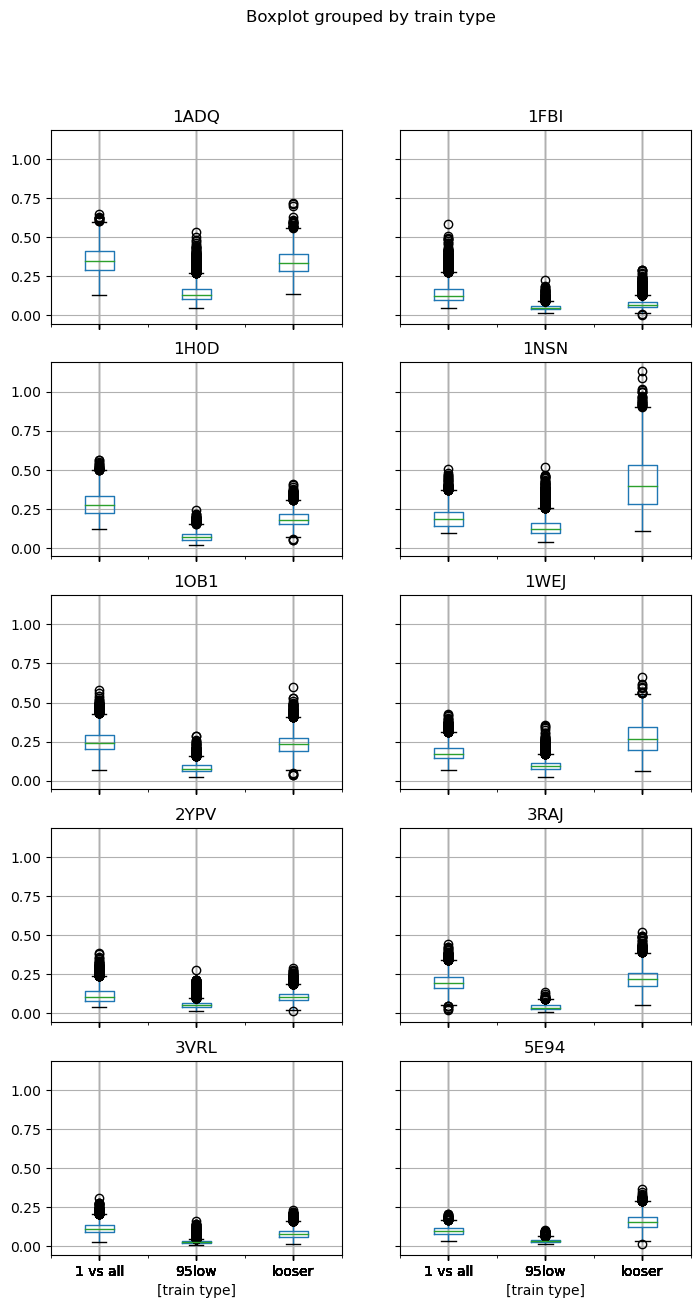

In [189]:
df_all_dist.boxplot(by='train type', figsize = (8,15), layout = (5,2));

##old importances

In [16]:
imp_path

['../data/Slide_importance/1OB1_C_Task4_Slice_ParaEpi.txt']

In [152]:
#save ig for all ant by incorporating ant to pd name
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_1_vs_all/swa_exp'
dic_ag_ig_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(ONE_VS_ALL_PATH / f'{ag}_vs_all.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_vs_all_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root)
    df_imp_pred.to_csv(f'./logs/{ag}_swa_1_vs_all_ig.txt', sep='\t')
    df_igs = df_imp_pred.filter(regex=("1_vs_all_repl_\d*_ig"))
    igs = df_igs.apply(ig_difference, axis=1).values
    dic_ag_ig_dist[ag] = igs

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [153]:
base_model = SN10()
model_root = 'SN10_1_vs_all/base_exp'
dic_ag_ig_dist_base = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(ONE_VS_ALL_PATH / f'{ag}_vs_all.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_vs_all_repl'
    model_suffix =  ''
    df_imp_pred = df_ig(df_closed, df_imp, base_model, model_prefix, model_suffix, model_root)
    df_imp_pred.to_csv(f'./logs/{ag}_base_1_vs_all_ig.txt', sep='\t')
    df_igs = df_imp_pred.filter(regex=("1_vs_all_repl_\d*_ig"))
    igs = df_igs.apply(ig_difference, axis=1).values
    dic_ag_ig_dist_base[ag] = igs

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [157]:
#high_low
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_high_low'
dic_ag_ig_hlow_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(HIGH_LOW_PATH / f'{ag}_high_95low.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_high_95low_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root)
    df_imp_pred.to_csv(f'./logs/{ag}_swa_high_low_ig.txt', sep='\t')
    df_igs = df_imp_pred.filter(regex=("1_vs_all_repl_\d*_ig"))
    igs = df_igs.apply(ig_difference, axis=1).values
    dic_ag_ig_hlow_dist[ag] = igs

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [158]:
#high_looser
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_root = 'SN10_high_low'
dic_ag_ig_hlooser_dist = dict()
for ag in tqdm(antigens, desc = 'Antigens'):
    df_closed = pd.read_csv(HIGH_LOW_PATH / f'{ag}_high_looser.tsv', sep ='\t')
    imp_path = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    df_imp = pd.read_csv(imp_path, sep = '\t')
    model_prefix = f'{ag}_high_looser_hard_repl'
    model_suffix =  '_swa'
    df_imp_pred = df_ig(df_closed, df_imp, swa_model, model_prefix, model_suffix, model_root)
    df_imp_pred.to_csv(f'./logs/{ag}_swa_high_looser_ig.txt', sep='\t')
    df_igs = df_imp_pred.filter(regex=("1_vs_all_repl_\d*_ig"))
    igs = df_igs.apply(ig_difference, axis=1).values
    dic_ag_ig_hlooser_dist[ag] = igs

Antigens:   0%|          | 0/10 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

replicates:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

Dataset:   0%|          | 0/7350 [00:00<?, ?it/s]

In [27]:
dic_ag_ig_dist

{'3VRL': array([0.05990305, 0.19413424, 0.11727547, ..., 0.16754182, 0.08770289,
        0.1261236 ]),
 '1NSN': array([0.16359859, 0.38989951, 0.31508122, ..., 0.22585684, 0.25224934,
        0.20038015]),
 '3RAJ': array([0.28110428, 0.22644555, 0.19097001, ..., 0.35587148, 0.33552266,
        0.23187612]),
 '5E94': array([0.10329448, 0.07608863, 0.08376074, ..., 0.08105555, 0.12134771,
        0.13953727]),
 '1H0D': array([0.29781441, 0.24916051, 0.17439739, ..., 0.17737768, 0.32799651,
        0.38019257]),
 '1WEJ': array([0.23963628, 0.19094492, 0.15684869, ..., 0.22693843, 0.18948275,
        0.18333579]),
 '1ADQ': array([0.40583267, 0.38221602, 0.29727736, ..., 0.38922255, 0.35415382,
        0.44619328]),
 '1FBI': array([0.11971822, 0.09470649, 0.0839741 , ..., 0.15810827, 0.11211789,
        0.08119518]),
 '2YPV': array([0.10587718, 0.09512692, 0.1819147 , ..., 0.22634937, 0.22620267,
        0.23825204]),
 '1OB1': array([0.19433787, 0.15275814, 0.16975026, ..., 0.15085359, 0.25

In [165]:
dic_ag_ig_hlooser_dist

{'3VRL': array([0.09397139, 0.11934985, 0.12945364, ..., 0.14401471, 0.1871516 ,
        0.17562224]),
 '1NSN': array([0.4045244 , 0.30121529, 0.22176392, ..., 0.24317564, 0.36611516,
        0.20319793]),
 '3RAJ': array([0.14104975, 0.13064329, 0.09199715, ..., 0.17128759, 0.1645964 ,
        0.19476577]),
 '5E94': array([0.12741404, 0.13175681, 0.10026012, ..., 0.17282468, 0.11876526,
        0.08822225]),
 '1H0D': array([0.17208984, 0.217875  , 0.22542125, ..., 0.24904153, 0.14919919,
        0.13408342]),
 '1WEJ': array([0.21151854, 0.43607772, 0.20635365, ..., 0.143813  , 0.15967144,
        0.21219613]),
 '1ADQ': array([0.35163951, 0.33955436, 0.29389895, ..., 0.38166878, 0.28451278,
        0.2605452 ]),
 '1FBI': array([0.15080031, 0.15700793, 0.11960978, ..., 0.18326223, 0.14329694,
        0.18756822]),
 '2YPV': array([0.13088915, 0.11340553, 0.16825578, ..., 0.11546279, 0.13427278,
        0.10291383]),
 '1OB1': array([0.16370976, 0.27846188, 0.323651  , ..., 0.29083705, 0.15

In [191]:
df_ig_hlooser_dist= pd.DataFrame.from_dict(dic_ag_ig_hlooser_dist, orient = 'columns')
n = df_ig_hlooser_dist.shape[0]
df_ig_hlooser_dist['train type'] = ['hlooser']*n
df_ig_hlow_dist = pd.DataFrame.from_dict(dic_ag_ig_hlow_dist, orient = 'columns')
df_ig_hlow_dist['train type'] = ['hlow']*n
df_ig_dist_base = pd.DataFrame.from_dict(dic_ag_ig_dist_base, orient = 'columns')
df_ig_dist_base['train type'] = ['all_base']*n
df_ig_dist_swa= pd.DataFrame.from_dict(dic_ag_ig_dist, orient = 'columns')
df_ig_dist_swa['train type'] = ['all_swa']*n

In [192]:
df_all_dist = pd.concat([df_ig_dist_swa, df_ig_dist_base, df_ig_hlooser_dist, df_ig_hlow_dist], axis = 0).reset_index(drop =True)

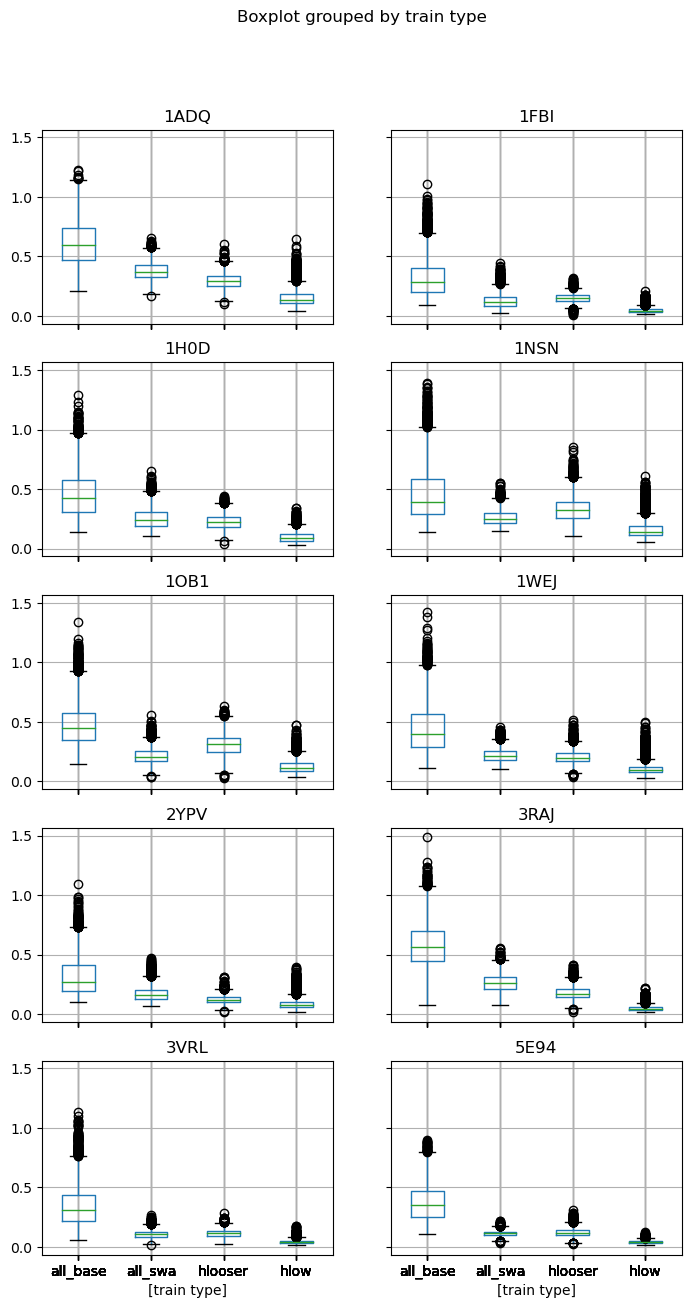

In [193]:
df_all_dist.boxplot(by='train type', figsize = (8,15), layout = (5,2));

In [ ]:
#it seems that base has a higer values of IG